In this notebook, we're going to revisit the classification model we trained to distinguish between malignant and benign skin lesions in the hopes of improving its test accuracy. Most of the code in this notebook is copied from the previous session, but parts will be adjusted to boost the model performance.

# Important: Run this code cell each time you start a new session!

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install os
!pip install opencv-python
!pip install scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import sklearn

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [ ]:
!wget -Ncnp https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip

--2023-07-31 21:46:24--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 3.5.25.222, 52.216.109.59, 52.217.174.217, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|3.5.25.222|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘ISBI2016_ISIC_Part3_Training_Data.zip’ not modified on server. Omitting download.



In [ ]:
!unzip -n ISBI2016_ISIC_Part3_Training_Data.zip

Archive:  ISBI2016_ISIC_Part3_Training_Data.zip


In [ ]:
!wget -Ncnp https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv

--2023-07-31 21:46:26--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 3.5.25.222, 52.216.109.59, 52.217.174.217, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|3.5.25.222|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘ISBI2016_ISIC_Part3_Training_GroundTruth.csv’ not modified on server. Omitting download.



In [ ]:
!wget -Ncnp https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_GroundTruth.zip

--2023-07-31 21:46:26--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 3.5.25.222, 52.216.109.59, 52.217.174.217, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|3.5.25.222|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘ISBI2016_ISIC_Part1_Training_GroundTruth.zip’ not modified on server. Omitting download.



In [ ]:
!unzip -n ISBI2016_ISIC_Part1_Training_GroundTruth.zip

Archive:  ISBI2016_ISIC_Part1_Training_GroundTruth.zip


# Step 1: Define the Problem We Are Trying to Solve

As before, our overarching goal is to generate a binary classification model that predicts whether the skin lesion in a photograph is benign or malignant. We will consider the latter to be our positive class.

In [ ]:
# The relevant folders and files associated with this dataset
# (we will talk about some of them later)
image_folder = 'ISBI2016_ISIC_Part3_Training_Data'
segementation_folder = 'ISBI2016_ISIC_Part1_Training_GroundTruth'
label_file = 'ISBI2016_ISIC_Part3_Training_GroundTruth.csv'

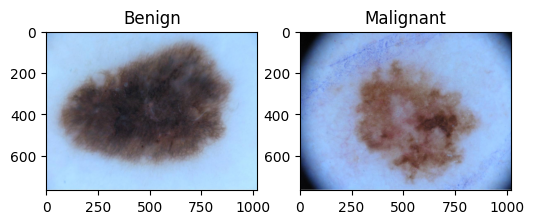

In [ ]:
# Load two pre-selected image files to show what they look like
benign_filename = 'ISIC_0000000.jpg'
malignant_filename = 'ISIC_0000002.jpg'
benign_img = cv2.imread(os.path.join(image_folder, benign_filename))
benign_img = cv2.cvtColor(benign_img, cv2.COLOR_BGR2RGB)
malignant_img = cv2.imread(os.path.join(image_folder, malignant_filename))
malignant_img = cv2.cvtColor(malignant_img, cv2.COLOR_BGR2RGB)

# Show the images and their labels
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1), plt.imshow(benign_img), plt.title('Benign')
plt.subplot(1, 2, 2), plt.imshow(malignant_img), plt.title('Malignant')
plt.show()

# Step 2: Create Your Features and Labels

We are going to keep our labels and features the same as before. All of the code from the previous session is copied below, so refer to that notebook if you need a reminder of how we came up with these code blocks.

In [ ]:
# Generate labels
labels_df = pd.read_csv(label_file, header=None)
labels_df.rename(columns={0: 'Image Name', 1: 'Label'}, inplace=True)
labels_df.set_index(['Image Name'], inplace=True)
labels_df['Label'].replace({'benign': 0, 'malignant': 1}, inplace=True)

In [ ]:
# Helper function for extracting contour from annotation
def extract_contour(seg_img):
    """
    Extracts the lone contour from the image annotation
    seg_img: a binary image representing an annotation
    """
    cnts, hierarchy = cv2.findContours(seg_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return cnts[0]

In [ ]:
from scipy.spatial.distance import cdist

# Helper functions for calculating our custom asymmetry score
def rotate_contour(cnt, angle, center):
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_contour = cv2.transform(cnt.reshape(-1, 1, 2), rotation_matrix).reshape(-1, 2).astype(int)
    return rotated_contour

def flip_contour_horiz(cnt, width):
    return np.array([[[width - point[0][0], point[0][1]] for point in cnt]], dtype=np.int32)

def get_hausdorff_distance(cnt1, cnt2):
    pts1 = np.array(cnt1).squeeze()
    pts2 = np.array(cnt2).squeeze()
    distances = cdist(pts1, pts2)
    return np.max(np.min(distances, axis=0))

In [ ]:
def compute_asymmetry(img, cnt):
    """
    Compute the asymmetry of the skin lesion by comparing the contour with a
    reflected version of itself
    img: the image of the skin lesion
    cnt: the contour of the skin lesion
    """
    # Get the min enclosing ellipse
    center, axes, angle = cv2.fitEllipse(cnt)

    # Rotate the contour so that it is upright
    rotated_cnt = rotate_contour(cnt, angle, center)

    # Flip the contour horizontally
    flipped_rotated_cnt = flip_contour_horiz(cnt, img.shape[1])

    distance = get_hausdorff_distance(rotated_cnt, flipped_rotated_cnt)

    # Compute the diameter of the contour
    _, r = cv2.minEnclosingCircle(cnt)
    d = 2*r

    # Compute the symmetry score
    return distance / d

In [ ]:
def compute_border(cnt):
    """
    Compute the jaggedness of the skin lesion's border by comparing the
    perimeter of the actual border to the perimeter of a smoothed version of it
    cnt: the contour of the skin lesion
    """
    # Compute the perimeter
    perimeter = cv2.arcLength(cnt, True)

    # Approximate the contour as a convex hull
    epsilon = 0.01 * perimeter
    approx = cv2.approxPolyDP(cnt, epsilon, True)

    # Compute the perimeter of the convex hull
    simplified_perimeter = cv2.arcLength(approx, True)

    # Return the ratio between the two
    return simplified_perimeter / perimeter

In [ ]:
def compute_color(img, cnt):
    """
    Compute the average color of the skin lesion within the contour
    img: the image of the skin lesion
    cnt: the contour of the skin lesion
    """
    # Convert the image to HSV
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Recreate the binary mask using the contour
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [cnt], -1, (255), thickness=-1)

    # Apply the mask to the image
    # TODO: see if this changes things and remove otherwise???
    masked_img = cv2.bitwise_and(img, img, mask=mask)

    # Compute the average HSV color
    return cv2.mean(masked_img, mask=mask)[:3]

In [ ]:
def compute_diameter(cnt):
    """
    Compute the radius of the skin lesion according to the min enclosing circle
    cnt: the contour of the skin lesion
    """
    _, r = cv2.minEnclosingCircle(cnt)
    return 2*r

In [ ]:
def process_img(filename):
    """
    Process a skin lesion image and produce all of the features according to
    the ABCD(E) rule as a dictionary (one value per key)
    filename: the name of the skin lesion image without the file extension
    """
    # Get the contour filename
    rgb_filename = filename + '.jpg'
    seg_filename = filename + '_Segmentation.png'

    # Get both of the images (RGB and segmentation annotation)
    img = cv2.imread(os.path.join(image_folder, rgb_filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    seg_img = cv2.imread(os.path.join(segementation_folder, seg_filename))
    seg_img = cv2.cvtColor(seg_img, cv2.COLOR_BGR2GRAY)

    # Get the contour
    cnt = extract_contour(seg_img)

    # Extract features from the image
    asymmetry = compute_asymmetry(img, cnt)
    border = compute_border(cnt)
    color = compute_color(img, cnt)
    diameter = compute_diameter(cnt)
    feature_dict = {'Asymmetry': asymmetry,
                    'Border': border,
                    'Color (H)': color[0],
                    'Color (S)': color[1],
                    'Color (V)': color[2],
                    'Diameter': diameter}

    # Combine everything into a feature vector
    return feature_dict

In [ ]:
# Get all the filenames but remove the extension
img_filenames = os.listdir(image_folder)
img_filenames = sorted([f[:-4] for f in img_filenames])

# Iterate through the filenames
features_df = pd.DataFrame()
for img_filename in img_filenames:
    # Generate the features
    feature_dict = process_img(img_filename)

    # Add the image name
    feature_dict['Image Name'] = img_filename
    feature_df = pd.DataFrame([feature_dict])
    features_df = pd.concat([features_df, feature_df], axis=0)

# Set the index to the image name
features_df.set_index(['Image Name'], inplace=True)
features_df.head()

,Asymmetry,Border,Color (H),Color (S),Color (V),Diameter
Image Name,,,,,,
ISIC_0000000,0.264907,0.877928,86.632871,78.636808,84.051231,865.640381
ISIC_0000001,0.139852,0.827353,78.426580,52.943311,41.744479,296.289154
ISIC_0000002,0.229542,0.795672,129.650357,107.868072,111.128415,646.436462
ISIC_0000004,0.247067,0.941746,187.453682,127.536826,154.028681,677.091003
ISIC_0000006,0.242043,0.815090,118.679519,100.910330,91.096321,367.912750


In [ ]:
df = features_df.merge(labels_df, left_index=True, right_index=True)
df.head()

,Asymmetry,Border,Color (H),Color (S),Color (V),Diameter,Label
Image Name,,,,,,,
ISIC_0000000,0.264907,0.877928,86.632871,78.636808,84.051231,865.640381,0
ISIC_0000001,0.139852,0.827353,78.426580,52.943311,41.744479,296.289154,0
ISIC_0000002,0.229542,0.795672,129.650357,107.868072,111.128415,646.436462,1
ISIC_0000004,0.247067,0.941746,187.453682,127.536826,154.028681,677.091003,1
ISIC_0000006,0.242043,0.815090,118.679519,100.910330,91.096321,367.912750,0


# Step 3: Decide How the Data Should Be Split for Training and Testing

Similar to before, we are going to use an 80%-20% split to train and test our model. All of the code from the previous session is copied below, so refer to that notebook if you need a reminder of how we came up with these code blocks.

In [ ]:
from sklearn.model_selection import train_test_split

# Set the random seed to an arbitrary number of your choosing
np.random.seed(42)

# Split off 20% of the data for model testing
train_df, test_df = train_test_split(df, test_size=0.2)

# Show the results
print(f'Number of samples in train data: {len(train_df)}')
print(f'Number of samples in test data: {len(test_df)}')

Number of samples in train data: 720
Number of samples in test data: 180


In [ ]:
x_train = train_df.drop('Label', axis=1).values
y_train = train_df['Label'].values
x_test = test_df.drop('Label', axis=1).values
y_test = test_df['Label'].values

# Step 4: (Optional) Add Feature Selection

Given that we only have a few features and they are informed by domain expertise, we are going to skip this step and assume that we have a reasonable set of features.

# Step 5: (Optional) Balance Your Dataset

Recall that our dataset was fairly imbalanced:

In [ ]:
def print_label_dist(y):
    """
    Prints out the balance between positive and negative samples
    y: a 1D array of labels
    """
    num_neg = np.count_nonzero(y == 0)
    num_pos = np.count_nonzero(y == 1)
    print(f'Number of benign samples: {num_neg}')
    print(f'Number of malignant samples: {num_pos}')
    print(f'Fraction of positive samples: {num_pos/(num_pos+num_neg):0.2f}')

In [ ]:
print_label_dist(df['Label'].values)

Number of benign samples: 727
Number of malignant samples: 173
Fraction of positive samples: 0.19


In [ ]:
print_label_dist(y_train)

Number of benign samples: 579
Number of malignant samples: 141
Fraction of positive samples: 0.20


In [ ]:
print_label_dist(y_test)

Number of benign samples: 148
Number of malignant samples: 32
Fraction of positive samples: 0.18


The [`imbalanced-learn`](https://imbalanced-learn.org/stable/)  library provides support for various techniques that address dataset imbalance.

To increase the number of malignant samples in our dataset, we are going to use the Synthetic Minority Oversampling Technique (SMOTE).

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
x_train_balanced, y_train_balanced = sm.fit_resample(x_train, y_train)

In [ ]:
print_label_dist(y_train_balanced)

Number of benign samples: 579
Number of malignant samples: 579
Fraction of positive samples: 0.50


Notice that we only apply SMOTE on our training data. This is because we should **never** be touching our test data until we are ready to evaluate our model, and it wouldn't make sense to evaluate our model on synthetic data.

# Step 6: Select an Appropriate Model

We will use the same random forest classifier as before.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

# Step 7: Select Your Hyperparameters

## Deciding Which Hyperparameters to Optimize

The random forest classifier has many different hyperparameters we can tune. We can find the full list of hyperparameters along with their current settings (currently the defaults) using the `.get_params()` method:

In [ ]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Not all of these dictionary entries are hyperparameters. For example, the `verbose` parameter is simply a flag that indicates whether you want Python to print out more information whenever you are calling a method on your model.

Trying to optimize every single hyperparameter requires a lot of time with marginal benefits. Rather, it generally makes sense to become familiar with the classifier you are using and deciding for yourself which hyperparameters you think are going to have the most impact on model performance. For our classifier, we are just going to optimize three hyperparameters:
1. ***n_estimators:*** The number of trees in the random forest
2. ***criterion:*** The metric used to measure the quality of a decision tree split
3. ***max_depth:*** The maximum number of decisions that can be made in a given decision tree

Why did we pick these three? They happen to be the first three in `scikit-learn`'s [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), which is usually a good indicator that these are going to be interesting ones to optimize.

It's also difficult to try an infinite number of settings for each hyperparameter. Therefore, we are going to create a dictionary that specifies the settings that we want to try out:

In [ ]:
param_grid = {'n_estimators': [25, 50, 100, 200],
              'criterion' : ['gini', 'entropy', 'log_loss'],
              'max_depth': [2, 5, 10, None]}

How did we know which settings to try? It requires a combination of familiarity with the model and reading documentation. Here is the intuition behind the options laid out above:
1. ***n_estimators:*** The default is 100, so it makes sense to try some configurations with fewer estimators and some configurations with more estimators.
2. ***criterion:*** Only a few possible settings are allowed since this hyperparameter refers to names of metrics for measuring the impurity of decision tree splits.
3. ***max_depth:*** The default is `None`, which implies that a given decision tree can split as many times as needed until all of the leaves (i.e., the ends of the decision tree) are relatively pure. However, this can enable very convoluted and specific decision criteria that lead to overfitting, so we can try some settings to restrict the depth of our trees to see if that helps.

This still explains neither the number of settings we plan to try out nor the spacing between the settings. Unfortunately, that comes with experience and trial-and-error. Bear in mind that while trying more options can make you more confident in the outcome, it means that our code will take longer to run.

## Optimizing the Hyperparameters

We are going to use 5-fold cross-validation on our training set to optimize our hyperparameters. This will give us access to far more data for hyperparameter tuning than if we separated out a distinct chunk of data from our training set to serve as our validation set.

As a reminder, k-fold cross-validation involves splitting data into $k$ distinct chunks and then training $k$ different models such that each chunk serves as the test set once.

Many hyperparameters are often intertwined. For example, increasing the number of estimators in your model may mean that your trees can be shallow. Therefore, it makes sense to optimize all of the hyperparameters at the same time rather than one at a time.

We are going to use a ***grid search*** to systematically try all possible combinations of hyperparameter settings that we've laid out above. The pseudocode below outlines how this procedure will look for our example:

```
for n_estimators in [25, 50, 100, 200]:
    for criterion in ['gini', 'entropy', 'log_loss']:
        for max_depth in [2, 5, 10, None]:
            train the model using these settings
            if model better than any model from before:
                save the settings
```

`scikit-learn` provides a `GridSearchCV` class that will do this procedure for us. We are going to specify four parameters in this class:
1. ***estimator:*** A model architecture
2. ***param_grid:*** A dictionary specifying the hyperparameters and settings that we'd like to test
3. ***cv:*** The number of folds in our k-fold cross-validation scheme
4. ***verbose:*** Setting this flag to `3` will print detailed information about what is happening in the function. We will only do this for the sake of verifying what is happening in our code.

As a small detail, we will need to set the random seed for the model we use for this procedure in particular since it is separate from the random seed used by `numpy`. This detail can be ignored once you are ready to truly test your pipeline.

In [ ]:
from sklearn.model_selection import GridSearchCV
grid_search_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(grid_search_model, param_grid,
                           cv=5, verbose=3)

grid_result = grid_search.fit(x_train, y_train)
best_params = grid_result.best_params_
print(f'Best Params: {grid_result.best_params_}')
print(f'Best Score: {grid_result.best_score_}')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END criterion=gini, max_depth=2, n_estimators=25;, score=0.806 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, n_estimators=25;, score=0.806 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, n_estimators=25;, score=0.806 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, n_estimators=25;, score=0.799 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, n_estimators=25;, score=0.799 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, n_estimators=50;, score=0.806 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, n_estimators=50;, score=0.806 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, n_estimators=50;, score=0.806 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, n_estimators=50;, score=0.799 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, n_estimators=50;, score=0.799 total time=   0.1s
[CV 1/5] END criterion=gini,

As it turns out, our optimal hyperparameters for our task are all different from `scikit-learn`'s default settings. It seems that limiting the depth of our trees and reducing the number of estimators led to better performance. These settings translate to a model with less flexibility, which may lead to better generalization down the road.

Once we have identified the optimal hyperparameters, we will need to set those values in the model that we plan to actually train and test. We can do this by creating a new model as follows:

In [ ]:
clf = RandomForestClassifier(**best_params)

Note that `**best_params` unpacks the dictionary of best parameters into keyword arguments for the model's constructor.

# Step 8: Train and Test Your Model

We will train and test our model as we have in the past, but with two key differences:
1. We have optimized the hyperparameters of the random forest
2. We will train our data using the balanced dataset provided by SMOTE

In [ ]:
clf.fit(x_train_balanced, y_train_balanced)

RandomForestClassifier(criterion='log_loss', max_depth=10, n_estimators=200)

In [ ]:
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

In [ ]:
y_binary = clf.predict(x_train[:10, :])
y_prob = clf.predict_proba(x_train[:10, :])

In [ ]:
y_train_pred_prob = clf.predict_proba(x_train)[:, 1]
y_test_pred_prob = clf.predict_proba(x_test)[:, 1]

# Step 9: Use an Appropriate Method for Interpreting Results

We are going to use the same function we created earlier to view the classification accuracy of our model.

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

classes = ['benign', 'malignant']
def classification_evaluation(y_true, y_pred, y_pred_prob):
    """
    Generate a series of graphs that will help us determine the performance of
    a binary classifier model
    y_true: the target binary labels
    y_pred: the predicted binary labels
    y_pred_prob: the predicted likelihood scores for a positive label
    """
    # Calculate f1 score, sensitivity, and specificity
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    f1 = f1_score(y_true, y_pred)
    sens = tp / (tp+fn)
    spec = tn / (tn+fp)

    # Generate the confusion matrix
    cm_title = f'Confusion Matrix \n(Sensitivity: {sens:0.2f}, Specificity: {spec:0.2f})'
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=classes)
    plt.title(cm_title)
    plt.show()

    # Display the ROC curve
    roc_title = f'ROC Curve (F1 score: {f1:0.2f})'
    RocCurveDisplay.from_predictions(y_true, y_pred_prob)
    plt.title(roc_title)
    plt.show()

Without dataset balancing and hyperparameter tuning, we achieved perfect accuracy on our training data; however, we only achieved an F1 score of 0.10 on our test data. Let's see what happens when we evaluate our new model (note that we evaluating training accuracy only on real data before SMOTE was applied):

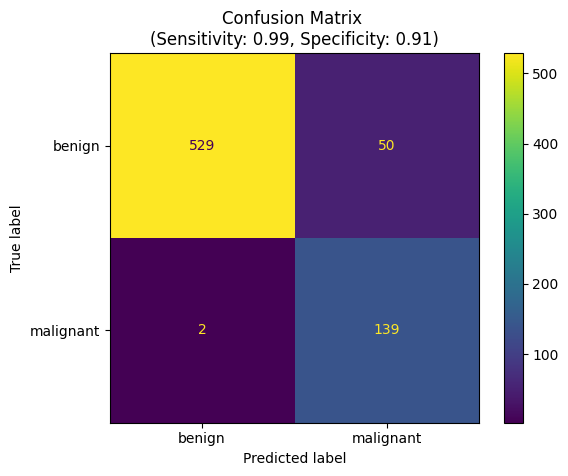

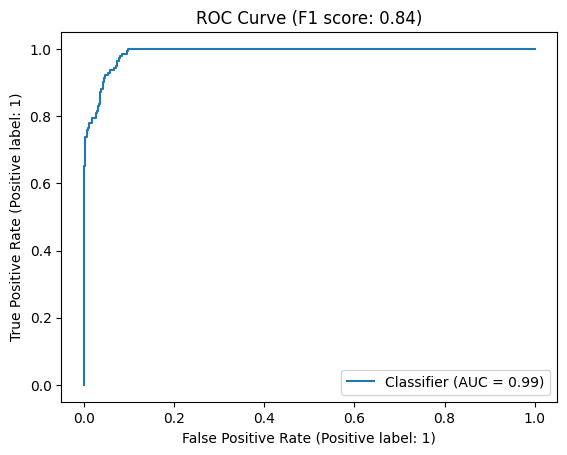

In [ ]:
classification_evaluation(y_train, y_train_pred, y_train_pred_prob)

Because we chose hyperparameters that made our model less flexible, we actually see a slight drop in training accuracy. Nevertheless, it seems like the model is still learning from the features in order to provide useful predictions on the training set.

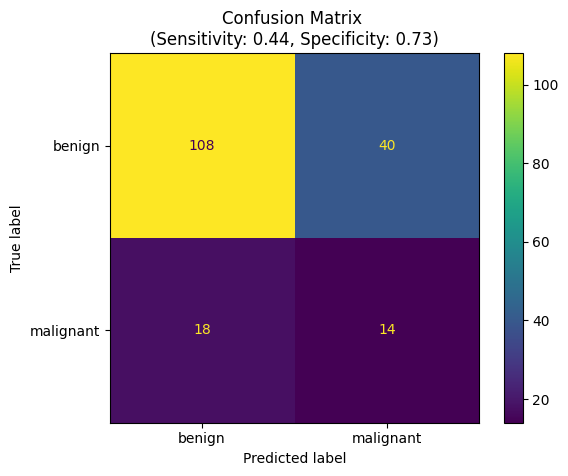

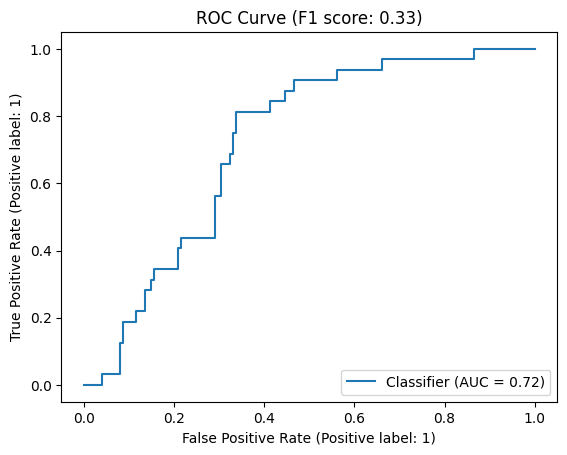

In [ ]:
classification_evaluation(y_test, y_test_pred, y_test_pred_prob)

Although the model performance isn't stellar, we can see that our changes led to an improvement in our test accuracy. While we only achieved an F1 score of 0.10 before, we have now bumped the F1 score to 0.33! Since we made multiple changes to our pipeline at the same time, we can't say for certain which change led to the bigger improvement, but clearly we're heading in the right direction.

So what are some things we could do to push the performance further? Here are some ideas:
* **Refine our current features:** We made some assumptions about the best way to represent various characteristics of the skin lesion. For example, we decided that the HSV color space would be the best way to represent color, but perhaps another color space may have yielded better results.
* **Examine more features:** All of our features were inspired by the ABCDE rule of dermatology. While it is strongly recommended that you ground your features in domain expertise, data science gives you the opportunity to push the limits of what humans can do. For example, maybe the ABCDE rule hasn't included anything about speckling patterns within skin lesions because it's hard to perceive such patterns with the naked eye. Using image processing, we can explore for ourselves whether we can extract such information and whether it can be useful for predicting
* **More data:** Roughly 20% of our dataset included malignant skin lesions. Although we used SMOTE to balance our training split, remember that the synthetic examples can only be made from existing data. If possible, it would have been better if we could have intentionally collected more images of malignant skin lesions to round out our dataset.